## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_calibration_params():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Perspective transform

In [2]:
def get_perspective_transform():
#     585, 460–320, 0
#     203, 720–320, 720
#     1127, 720–960, 720
#     695, 460–960, 0
    
    #top right cc
#     src_coord = np.array([
#         [700, 460],
#         [588, 460],
#         [320, 650],
#         [994, 650]
#     ],dtype = "float32")
    src_coord = np.array([
        [748, 492],
        [539, 492],
        [307, 660],
        [1005, 660]
    ],dtype = "float32")

#     dest_coord = np.array([
#         [974, 300],
#         [300, 300],
#         [300, 1500],
#         [974, 1500]
#     ],dtype = "float32")
#     dest_coord = np.array([
#         [880, 300],
#         [400, 300],
#         [400, 720],
#         [880, 720]
#     ],dtype = "float32")
    dest_coord = np.array([
        [980, 300],
        [300, 300],
        [300, 720],
        [980, 720]
    ],dtype = "float32")

    return cv2.getPerspectiveTransform(src_coord, dest_coord)

In [3]:
#some global variables
ret, mtx, dist, rvecs, tvecs = get_calibration_params()
transform_mat = get_perspective_transform()

#last found lane lines params
last_lc = None
last_rc = None
last_lx = None
last_rx = None

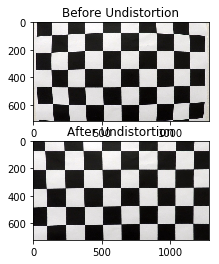

In [4]:
def test_undistortion():
    test_img = cv2.imread("../camera_cal/calibration1.jpg")
    undistort = cv2.undistort(test_img, mtx, dist, None, None)

    plt.subplot(211)
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.title("Before Undistortion")

    plt.subplot(212)
    plt.imshow(cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB))
    plt.title("After Undistortion")
    
test_undistortion()

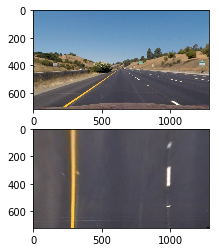

In [5]:
def test_pt1():
    sample_img = cv2.undistort(cv2.imread("../test_images/straight_lines1.jpg"), mtx, dist, None, None)
    img_size = list(sample_img.shape[:2][::-1])
    timg = cv2.warpPerspective(sample_img, transform_mat, (img_size[0], img_size[1]) )

    plt.subplot(211)
    plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB) )
    plt.subplot(212)
    plt.imshow(cv2.cvtColor(timg, cv2.COLOR_BGR2RGB))

test_pt1()


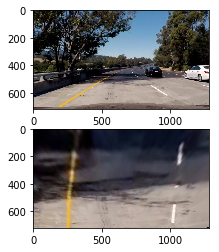

In [6]:
def test_pt2():
#     sample_img2 = cv2.undistort(cv2.imread("../test_images/diff.png"), mtx, dist, None, None)
    sample_img2 = cv2.undistort(cv2.imread("../test_images/test5.jpg"), mtx, dist, None, None)
    size2 = sample_img2.shape[:2][::-1]
    timg2 = cv2.warpPerspective(sample_img2, transform_mat, (size2[0], size2[1]))

    plt.subplot(211)
    plt.imshow(cv2.cvtColor(sample_img2, cv2.COLOR_BGR2RGB) )
    plt.subplot(212)
    plt.imshow(cv2.cvtColor(timg2, cv2.COLOR_BGR2RGB))
    
test_pt2()

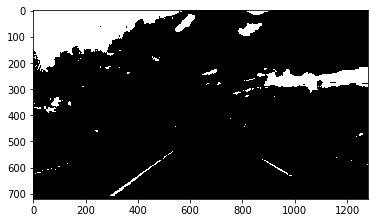

In [7]:
sample_img2 = cv2.undistort(cv2.imread("../test_images/diff.png"), mtx, dist, None, None)
s = cv2.cvtColor(sample_img2, cv2.COLOR_BGR2HLS)[:,:,2]
l  = cv2.cvtColor(sample_img2, cv2.COLOR_BGR2HLS)[:,:,1]
th = np.zeros_like(s)
th[(s > 100) & (s < 250) | (l > 200)] = 1
plt.imshow(th, cmap='Greys_r')

# Gradient/Color Thresholds

In [8]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(0, 255)):
    if orient == 'y':
        grad = cv2.Sobel(gray, cv2.CV_64F, 0,1)
    else:
        grad = cv2.Sobel(gray, cv2.CV_64F, 1,0)
    
    grad = np.abs(grad)
    grad = np.uint8(255*grad/np.max(grad))
    grad = grad.astype(np.uint8)
    
    binary_output = np.zeros_like(grad)
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(image, sobel_kernel=5, threshold=(200, 255)):
    xg = cv2.Sobel(image, cv2.CV_64F, 1, 0, sobel_kernel)
    yg = cv2.Sobel(image, cv2.CV_64F, 0, 1, sobel_kernel)
    gg = np.power( np.power(xg,2) + np.power(yg,2), 0.5)
    gg = (gg - gg.min())/(gg.max() - gg.min()) * 255
    gg = gg.astype(np.uint8)
    
    binary_output = np.zeros_like(gg)
    binary_output[ (gg > threshold[0]) & (gg < threshold[1])] = 1
    return binary_output

def dir_thresh(image, sobel_kernel=5, threshold=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= threshold[0]) & (absgraddir <= threshold[1])] = 1
    return binary_output

def get_threshold_image(color_img, color_threshold, dir_threshold, mag_threshold, x_threshold=(45, 255)):
    #convert to HSL color space
    hsl_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2HLS)
    h,l,s = hsl_img[:,:,0], hsl_img[:,:,1], hsl_img[:,:,2]

    #do color thresholding
    cthres = color_threshold
    color_t = np.zeros_like(s)
    #color_t[(s >= cthres[0]) & (s <= cthres[1]) | (l > 180)] = 1
    color_t[(s >= cthres[0]) & (s <= cthres[1])] = 1

    #do gradient thresholding
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    dir_t = dir_thresh(gray, threshold=dir_threshold)
    mag_t = mag_thresh(gray, threshold=mag_threshold)
    x_t = abs_sobel_thresh(gray, thresh=x_threshold)
        
    return color_t, dir_t, mag_t, x_t

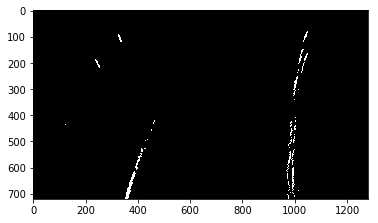

In [9]:
def test_gradients():
    img = cv2.imread("../test_images/diff.png")
    undistort = cv2.undistort(img, mtx, dist, None, None)
    
    color_t, dir_t, mag_t, x_t = get_threshold_image(undistort, color_threshold = (100, 250), dir_threshold = (0.7, 1.3),
                                                     mag_threshold = (50, 255))
    final_binary = np.zeros_like(color_t)
    final_binary[(color_t == 1) | ((mag_t == 1) & (x_t == 1))] = 1
    
    #3: perspective transform 
    img_size = img.shape[:2][::-1]
    timg = cv2.warpPerspective(final_binary, transform_mat, (img_size[0], img_size[1]) )
    plt.imshow(timg, cmap="Greys_r")
    
test_gradients()

In [10]:
def get_lane_lines(pt_binary):
    histogram = pt_binary[pt_binary.shape[0]//2:, :].sum(axis=0)

    midpt = int(histogram.shape[0]/2)
    left_mode = np.argmax(histogram[:midpt])
    right_mode = midpt + np.argmax(histogram[midpt:])

    #windows
    nwindows = 8
    lr_margin = 70
    min_wshift = 50
    smargin = 30

    max_height, max_width = pt_binary.shape
    w_height = max_height//nwindows

    cur_l = left_mode
    cur_r = right_mode

    xl_indices = np.array([])
    xr_indices = np.array([])
    yl_indices = np.array([])
    yr_indices = np.array([])

    vis_img = np.dstack((pt_binary, pt_binary, pt_binary)) * 255
    
    if last_lx is not None and last_rx is not None and not np.where((last_rx-last_lx) < 0)[0].any():
        #TODO: not exactly elegant
        last_lxi = last_lx.copy().astype(int)
        last_rxi = last_rx.copy().astype(int)
        #print("speed!")
        roi_l = np.zeros( (pt_binary.shape[0], smargin*2) )
        roi_r = np.zeros( (pt_binary.shape[0], smargin*2) )
        for i in range(last_lx.shape[0]):
            lidx = max(0, last_lxi[i])
            l = pt_binary[i, max(0, lidx - smargin): lidx + smargin]
            r = pt_binary[i, last_rxi[i] - smargin: last_rxi[i] + smargin]
            if l.shape[0] < smargin * 2:
                l = np.pad(l, (smargin * 2 - l.shape[0], 0), mode='constant')
            if r.shape[0] < smargin * 2:
                r = np.pad(r, (0, smargin*2 - r.shape[0]), mode='constant')
            
            #print(last_lxi[i], last_rxi[i])
            #print(roi_l.shape, roi_r.shape, l.shape, r.shape)
            roi_l[i, :] = l
            roi_r[i, :] = r
        
        ytmp_l, xtmp_l = np.nonzero(roi_l)
        ytmp_r, xtmp_r = np.nonzero(roi_r)
        xtmp_l += last_lx[ytmp_l].astype(int) - smargin
        xtmp_r += last_rx[ytmp_r].astype(int) - smargin
        
        yl_indices = ytmp_l
        xl_indices = xtmp_l
        yr_indices = ytmp_r
        xr_indices = xtmp_r
    
    if xl_indices.size == 0 or xr_indices.size == 0:
        xl_indices = np.array([])
        xr_indices = np.array([])
        yl_indices = np.array([])
        yr_indices = np.array([])
        #process lr mode separately
        for window in range(nwindows):
            y_c = window * w_height

            #draw bounding box
            cv2.rectangle(vis_img, (cur_l-lr_margin, max_height-y_c-w_height), (cur_l+lr_margin, max_height-y_c), (0,255,0),5 )
            cv2.rectangle(vis_img, (cur_r-lr_margin, max_height-y_c-w_height), (cur_r+lr_margin, max_height-y_c), (0,255,0),5 )

            roi_l = pt_binary[max_height-y_c-w_height: max_height-y_c, cur_l - lr_margin: cur_l + lr_margin]
            roi_r = pt_binary[max_height-y_c-w_height: max_height-y_c, cur_r - lr_margin: cur_r + lr_margin]

            ytmp_l, xtmp_l = np.nonzero(roi_l)
            ytmp_r, xtmp_r = np.nonzero(roi_r)

            xtmp_r += cur_r - lr_margin
            xtmp_l += cur_l - lr_margin

            ytmp_l += max_height - y_c - w_height
            ytmp_r += max_height - y_c - w_height

            yl_indices = np.append( yl_indices, ytmp_l) 
            xl_indices = np.append( xl_indices, xtmp_l) 
            yr_indices = np.append( yr_indices, ytmp_r) 
            xr_indices = np.append( xr_indices, xtmp_r)

            #shift window center
            if ytmp_l.shape[0] > min_wshift:
                cur_l = int(xtmp_l.mean())
            if ytmp_r.shape[0] > min_wshift:
                cur_r = int(xtmp_r.mean())

    #do 2-order polynomial fitting
    polyn_l = np.polyfit(yl_indices, xl_indices, 2)
    polyn_r = np.polyfit(yr_indices, xr_indices, 2)

    #y_l = np.polyval(polyn_l, np.arange(xl_indices.min(), xl_indices.max() + 1))
    #y_r = np.polyval(polyn_r, np.arange(midpt, max_width))
    #draw
    ploty = np.linspace(0, pt_binary.shape[0]-1, pt_binary.shape[0] )
    left_fitx = polyn_l[0]*ploty**2 + polyn_l[1]*ploty + polyn_l[2]
    right_fitx = polyn_r[0]*ploty**2 + polyn_r[1]*ploty + polyn_r[2]
    
    return left_fitx, ploty, right_fitx, ploty, vis_img

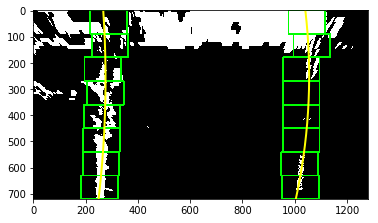

In [11]:
def test_windows():
    img = cv2.imread("../test_images/test5.jpg")
    undistort = cv2.undistort(img, mtx, dist, None, None)
    
    color_t, dir_t, mag_t, x_t = get_threshold_image(undistort, color_threshold = (100, 250), dir_threshold = (0.7, 1.3),
                                                     mag_threshold = (50, 255))
    final_binary = np.zeros_like(color_t)
    final_binary[(color_t == 1) | ((mag_t == 1) & (x_t == 1))] = 1
        
    #3: perspective transform 
    img_size = img.shape[:2][::-1]
    timg = cv2.warpPerspective(final_binary, transform_mat, (img_size[0], img_size[1]) )
    
    left_fitx, ploty, right_fitx, ploty, pt_binary = get_lane_lines(timg)
    plt.imshow(pt_binary)
    plt.plot(left_fitx, ploty, "yellow", linewidth=2)
    plt.plot(right_fitx, ploty, "yellow", linewidth=2)
    
test_windows()

# Calculate curvature of Left/Right Lane

In [12]:
def calculate_curvature(lx, ly, rx, ry, img_shape):
    #scale
    mpp_y = 30./720
    mpp_x = 3.7 /700
    
    #fit poly line in metres
    lm_fit = np.polyfit(ly * mpp_y, lx * mpp_x, 2)
    rm_fit = np.polyfit(ry * mpp_y, rx * mpp_x, 2)
    
    use_y = np.max(ly) * mpp_y#img_shape[0]
    
    l_curvature = 1 + (2 * lm_fit[0] * use_y + lm_fit[1])**2 
    l_curvature = np.abs( (l_curvature**1.5) / (2 * lm_fit[0]) )
    
    r_curvature = 1 + (2 * rm_fit[0] * use_y + rm_fit[1])**2 
    r_curvature = np.abs( (r_curvature**1.5) / (2 * rm_fit[0]) )
    
    return l_curvature, r_curvature
    

In [13]:
def test_curvature():
    img = cv2.imread("../test_images/test5.jpg")
    undistort = cv2.undistort(img, mtx, dist, None, None)
    
    color_t, dir_t, mag_t, x_t = get_threshold_image(undistort, color_threshold = (170, 250), dir_threshold = (0.7, 1.3),
                                                     mag_threshold = (60, 255))
    final_binary = np.zeros_like(color_t)
    final_binary[(color_t == 1) | ((mag_t == 1) & (dir_t == 1)) | (x_t ==1)] = 1
    
    img_size = img.shape[:2][::-1]
    timg = cv2.warpPerspective(final_binary, transform_mat, (img_size[0], img_size[1]) )
    
    left_fitx, ploty, right_fitx, ploty, pt_binary = get_lane_lines(timg)
    l_curvature, r_curvature = calculate_curvature(left_fitx, ploty, right_fitx, ploty, img.shape)
    
    print("left curvature: ", l_curvature, " right curvature: ", r_curvature)
    
test_curvature()

left curvature:  811.78833961  right curvature:  203402.044864


In [14]:
def calculate_radius(imgshape, left_p, right_p):
    mpp_y = 3.7 /700
    center_pixel = (left_p[-1] + right_p[-1])/2.
    offset = (imgshape[1]/2. - center_pixel) * mpp_y
    return offset

# Visualization

In [15]:
#Draw lane line:
def draw_detected_lane(org_img, lx, ly, rx, ry, transform_mat, lc, rc, offset):
    color_warp = np.zeros_like(org_img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([lx, ly]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rx, ry])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    shape = org_img.shape
    org_persp = cv2.warpPerspective(color_warp, np.linalg.inv(transform_mat), (shape[1], shape[0]) ) 

    result = cv2.addWeighted(org_img, 1, org_persp, 0.3, 0)
    
    text = "Curvature: (L)%.2f (R)%.2f"%(lc, rc)
    cv2.putText(result, text, (shape[0]//2, shape[1]//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    text2 = "Center offset: %.2f m"%offset
    cv2.putText(result, text2, (shape[0]//2, shape[1]//2 - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return result

# Lane Detection Pipeline

In [16]:
frame_id = 1
def do_lane_detection(img):
    global last_lc, last_rc, last_lx, last_rx, frame_id
    #1: undistortion
    undistort = cv2.undistort(img, mtx, dist, None, None)
    
    #2: gradient/color threshold
    color_t, dir_t, mag_t, x_t = get_threshold_image(undistort, color_threshold = (70, 200), dir_threshold = (0.7, 1.3),
                                                     mag_threshold = (65, 255))
    final_binary = np.zeros_like(color_t)
    final_binary[(color_t == 1) | (x_t == 1)] = 1
        
    #3: perspective transform 
    img_size = img.shape[:2][::-1]
    timg = cv2.warpPerspective(final_binary, transform_mat, (img_size[0], img_size[1]) )
    
    #4: lane detection
    left_fitx, ploty, right_fitx, ploty2, _ = get_lane_lines(timg)
    last_lx = left_fitx.copy()
    last_rx = right_fitx.copy()
    
    #5. curvature
    #cur_threshold = 10.
    lc, rc = calculate_curvature(left_fitx, ploty, right_fitx, ploty, img.shape)
    offset = calculate_radius(img.shape, left_fitx, right_fitx)
    
    #if last_lc and (abs(lc - last_lc) > cur_threshold or abs(rc - last_rc) > cur_threshold):
    #    last_rc, last_lc, last_lx, last_rx = None, None, None, None
    #    left_fitx, ploty, right_fitx, ploty2, _ = get_lane_lines(timg)
    #    last_lx = left_fitx.copy()
    #    last_rx = right_fitx.copy()
    #    lc, rc = calculate_curvature(left_fitx, ploty, right_fitx, ploty, img.shape)
    
    last_lc = lc
    last_rc = rc
    
    #6: draw lane
    vis_img = draw_detected_lane(undistort, left_fitx, ploty, right_fitx, ploty, transform_mat, lc, rc, offset)
    cv2.imwrite("/home/loc22/cy_work/secret/CarND-Advanced-Lane-Lines/CarND-Advanced-Lane-Lines/output_images/%s.png"%frame_id, vis_img)
    frame_id += 1
    return vis_img    

## Test lane finding on a Single Image

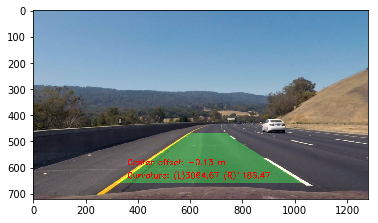

In [17]:
def test_lane_detection():
    img = cv2.imread("../test_images/test3.jpg")
    final = do_lane_detection(img)
    plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB), cmap='Greys_r')
    
test_lane_detection()

# Test lane detection on video

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def do_project():
    last_lc = None
    last_rc = None
    last_lx = None
    last_rx = None
    white_output = '../output_images/projectOutput.mp4'
    clip1 = VideoFileClip("../project_video.mp4")
    white_clip = clip1.fl_image(do_lane_detection)#.subclip(41,45)
    %time white_clip.write_videofile(white_output, audio=False)
do_project()


[MoviePy] >>>> Building video ../output_images/projectOutput.mp4
[MoviePy] Writing video ../output_images/projectOutput.mp4


  7%|▋         | 85/1261 [00:29<06:39,  2.95it/s]

KeyboardInterrupt: 

In [ ]:
def do_challenge_video():
    last_lc = None
    last_rc = None
    last_lx = None
    last_rx = None
    white_output = '../output_images/ChallengeOutput.mp4'
    clip1 = VideoFileClip("../challenge_video.mp4")
    white_clip = clip1.fl_image(do_lane_detection) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

do_challenge_video()